In [20]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from rdkit import Chem

# Load the original data with SMILES
url = 'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv'
df = pd.read_csv(url)

# Function to convert molecules to graph data objects
def mol_to_graph(smiles, y=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Get atom features
    num_atoms = mol.GetNumAtoms()
    
    # Simple atom features: atomic number and aromatic flag
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([
            atom.GetAtomicNum(),
            1 if atom.GetIsAromatic() else 0,
            atom.GetTotalDegree(),
            atom.GetFormalCharge(),
            atom.GetTotalNumHs()
        ])
    
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Get edge indices (bonds)
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()
        
        # Add both directions for undirected graph
        edge_indices.append([i, j])
        edge_indices.append([j, i])

        #Add same bond features for both directions
        edge_features.append([bond_type])
        edge_features.append([bond_type])
        
    if len(edge_indices) == 0:  # Handle molecules with no bonds
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0,1), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_features,dtype=torch.float)
    
    # Create data object
    data = Data(x=x, edge_index=edge_index,edge_attr=edge_attr)
    
    if y is not None:
        data.y = torch.tensor([y], dtype=torch.float)
        
    return data

# Convert SMILES to graph objects with solubility values
graph_data_list = []
target_column = 'measured log solubility in mols per litre'

for i, row in df.iterrows():
    smiles = row['smiles']
    y = row[target_column]
    data = mol_to_graph(smiles, y)
    if data is not None:
        graph_data_list.append(data)

# Split data
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [21]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, global_mean_pool, global_add_pool
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

class enhancedGNN(torch.nn.Module):
    def __init__(self,num_features=5,hidden_dim=64):
        super(enhancedGNN, self).__init__()

        #first GC layer
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        #second GC Layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        #third GC Layer
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        #Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32,1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # First conv block
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        # Second conv block
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Third conv block
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)
        
        # Fully connected layers
        x = F.dropout(x,p=0.2, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x.view(-1)

Epoch: 010, Train Loss: 1.3955, Test Loss: 1.2563
Epoch: 020, Train Loss: 1.2286, Test Loss: 1.2730
Epoch: 030, Train Loss: 1.3231, Test Loss: 1.2547
Early stopping triggered after epoch 37
Best model was at epoch 17 with test loss 1.2433
Final Test MSE: 1.2433
Final Test RMSE: 1.1151
Final Test R²: 0.7370


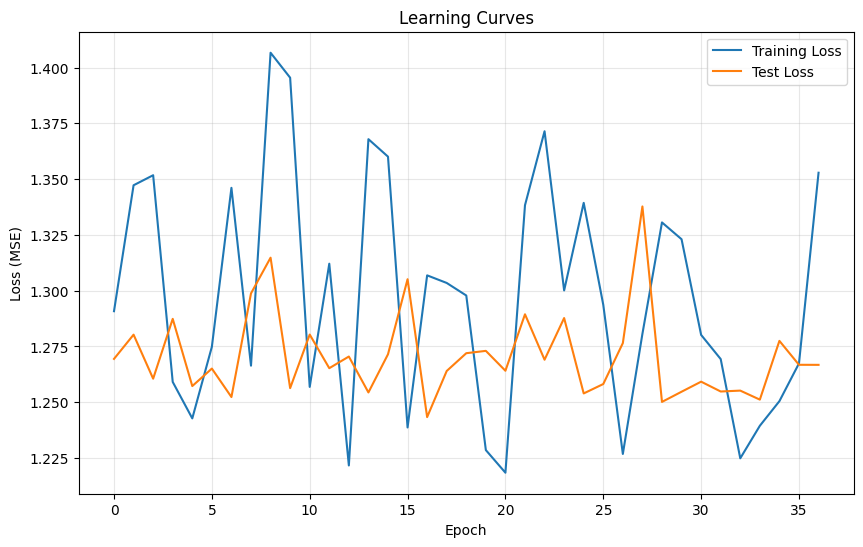

In [22]:
# Add the missing test function
def test(loader):
    model.eval()
    total_loss = 0
    predictions = []
    actual = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item() * data.num_graphs
            
            predictions.extend(output.cpu().numpy())
            actual.extend(data.y.cpu().numpy())
            
    return total_loss / len(loader.dataset), predictions, actual

# The complete training code with early stopping
def train_with_early_stopping(patience=20):
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    epochs_no_improve = 0
    
    # For tracking the learning curve
    train_losses = []
    test_losses = []
    
    for epoch in range(200):  # Increased max epochs
        train_loss = train()
        test_loss, _, _ = test(test_loader)
        
        # Store losses for plotting
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # Learning rate scheduling
        scheduler.step(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        # Check if this is the best model
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            print(f'Best model was at epoch {best_epoch+1} with test loss {best_loss:.4f}')
            break
    
    # Load best model for final evaluation
    model.load_state_dict(best_model_state)
    return best_epoch, best_loss, train_losses, test_losses

# Run training with early stopping
import copy
best_epoch, best_loss, train_losses, test_losses = train_with_early_stopping(patience=20)

# Final evaluation
_, test_pred, test_actual = test(test_loader)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(test_actual, test_pred)
r2 = r2_score(test_actual, test_pred)
rmse = np.sqrt(mse)

print(f'Final Test MSE: {mse:.4f}')
print(f'Final Test RMSE: {rmse:.4f}')
print(f'Final Test R²: {r2:.4f}')

# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('learning_curves.png', dpi=300)
plt.show()

In [23]:
# Save GNN results for later comparison
import joblib

# Save predictions
gnn_results = {
    'actual': test_actual,
    'predicted': test_pred,
    'mse': mean_squared_error(test_actual, test_pred),
    'rmse': np.sqrt(mean_squared_error(test_actual, test_pred)),
    'r2': r2_score(test_actual, test_pred)
}

joblib.dump(gnn_results, 'gnn_results.joblib')

['gnn_results.joblib']